In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import joblib

In [2]:
import os

In [19]:
import os
import glob
dataframes = []
csv_files = glob.glob(os.path.join('drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/', '*.csv'))
for file in csv_files:
  st_df = pd.read_csv(file, parse_dates=['timestamp'])
  symbol = file.split('/')[-1].split('_')[0]
  st_df['symbol'] = symbol
  dataframes.append(st_df)

df = pd.concat(dataframes, ignore_index=True)

In [20]:
df.shape

(3244268, 7)

In [3]:
df1 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/AXISBANK_historical_candle_data.csv", parse_dates=['timestamp'])
df1["symbol"] = "AXISBANK"
df2 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/TATAMOTORS_historical_candle_data.csv", parse_dates=['timestamp'])
df2["symbol"] = "TATAMOTORS"
df3 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/BAJFINANCE_historical_candle_data.csv", parse_dates=['timestamp'])
df3["symbol"] = "BAJFINANCE"
df4 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/TATASTEEL_historical_candle_data.csv", parse_dates=['timestamp'])
df4["symbol"] = "TATASTEEL"
df5 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/INFY_historical_candle_data.csv", parse_dates=['timestamp'])
df5["symbol"] = "INFY"
df6 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/APOLLOHOSP_historical_candle_data.csv", parse_dates=['timestamp'])
df6["symbol"] = "APOLLOHOSP"
df7 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/ULTRACEMCO_historical_candle_data.csv", parse_dates=['timestamp'])
df7["symbol"] = "ULTRACEMCO"
df8 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/ONGC_historical_candle_data.csv", parse_dates=['timestamp'])
df8["symbol"] = "ONGC"
df9 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/RELIANCE_historical_candle_data.csv", parse_dates=['timestamp'])
df9["symbol"] = "RELIANCE"
df10 = pd.read_csv("drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/Nifty_50_Historical_Data/SBILIFE_historical_candle_data.csv", parse_dates=['timestamp'])
df10["symbol"] = "SBILIFE"

In [4]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

In [5]:
df.index = df['timestamp']

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 668261 entries, 2022-01-03 09:15:00 to 2025-08-08 15:25:00
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  668261 non-null  datetime64[ns]
 1   open       668261 non-null  float64       
 2   high       668261 non-null  float64       
 3   low        668261 non-null  float64       
 4   close      668261 non-null  float64       
 5   volume     668261 non-null  int64         
 6   symbol     668261 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 72.0 MB


In [7]:
def temporal_split_by_time(df, test_size=0.2):
    """Split data by time across all stocks"""
    # Get unique timestamps and split temporally
    all_timestamps = df.index.unique().sort_values()
    split_index = int(len(all_timestamps) * (1 - test_size))
    split_time = all_timestamps[split_index]

    train_df = df[df.index < split_time].copy()
    test_df = df[df.index >= split_time].copy()

    return train_df, test_df

train_data, test_data = temporal_split_by_time(df)

In [8]:
def calculate_features(df):
    """
    Calculate features for multiple stocks in the same dataframe
    """
    # Make sure we have the required columns
    required_columns = ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    # df = df.reset_index()
    # Sort by symbol and datetime
    # df = df.sort_values(['symbol', 'timestamp']).copy()

    features_list = []

    # Process each stock separately
    for symbol, group in df.groupby('symbol'):
        symbol_df = group.copy()

        # Calculate returns
        symbol_df['returns'] = symbol_df['close'].pct_change()
        symbol_df['returns_5']  = symbol_df['close'].pct_change(5)
        symbol_df['log_returns'] = np.log(symbol_df['close']).diff()
        symbol_df['prev_close'] = symbol_df['close'].shift(1)
        symbol_df['vwap'] = (symbol_df['volume'] * (symbol_df['high'] + symbol_df['low'] + symbol_df['close']) / 3).cumsum() / symbol_df['volume'].cumsum()
        symbol_df['gap'] = (symbol_df['open'] - symbol_df['prev_close']) / symbol_df['prev_close'] * 100
        symbol_df['gap_abs'] = abs(symbol_df['gap'])
        symbol_df['gap_direction'] = np.where(symbol_df['gap'] > 0, 1, np.where(symbol_df['gap'] < 0, -1, 0))
        symbol_df['ema_8'] = symbol_df['close'].ewm(span=8).mean()
        symbol_df['ema_15'] = symbol_df['close'].ewm(span=15).mean()
        ema12 = symbol_df['close'].ewm(span=12, adjust=False).mean()
        ema26 = symbol_df['close'].ewm(span=26, adjust=False).mean()
        symbol_df['macd'] = ema12 - ema26
        symbol_df['macd_signal'] = symbol_df['macd'].ewm(span=9, adjust=False).mean()
        symbol_df['macd_hist'] = symbol_df['macd'] - symbol_df['macd_signal']
        for n in [5, 10, 20]:
         symbol_df[f'roc_{n}'] = symbol_df['close'].pct_change(periods=n)

        df['up_streak'] = df['close'].gt(df['close'].shift()).astype(int)
        df['up_streak'] = df['up_streak'] * (df['up_streak'].groupby((df['up_streak'] != df['up_streak'].shift()).cumsum()).cumsum())


        # Calculate up moves and down moves for RSI calculation
        symbol_df['up_move'] = np.where(symbol_df['close'] > symbol_df['close'].shift(1),
                                       symbol_df['close'] - symbol_df['close'].shift(1), 0)
        symbol_df['down_move'] = np.where(symbol_df['close'] < symbol_df['close'].shift(1),
                                         symbol_df['close'].shift(1) - symbol_df['close'], 0)

        symbol_df["sma_8"] = symbol_df["close"].rolling(window=8).mean()
        symbol_df["sma_20"] = symbol_df["close"].rolling(window=20).mean()

        symbol_df['sma8_above_sma20'] = (symbol_df['sma_8'] > symbol_df['sma_20']).astype(int)
        symbol_df['vwap_sma_20'] = symbol_df['vwap'].rolling(window=20).mean()
        symbol_df['vwap_ratio'] = symbol_df['vwap'] / symbol_df['vwap_sma_20']

        # --- VOLATILITY & RISK FEATURES ---
        # Calculate ATR (Average True Range)
        symbol_df['tr0'] = symbol_df['high'] - symbol_df['low']
        symbol_df['tr1'] = abs(symbol_df['high'] - symbol_df['close'].shift(1))
        symbol_df['tr2'] = abs(symbol_df['low'] - symbol_df['close'].shift(1))
        symbol_df['tr'] = symbol_df[['tr0', 'tr1', 'tr2']].max(axis=1)
        symbol_df['atr'] = symbol_df['tr'].rolling(20).mean()

        symbol_df['volatility_20'] = symbol_df['returns'].rolling(20).std()
        symbol_df['volatility_50'] = symbol_df['returns'].rolling(50).std()
        symbol_df['volatility_ratio'] = symbol_df['volatility_20'] / symbol_df['volatility_50']
        symbol_df['atr_pct'] = symbol_df['atr'] / symbol_df['close']

        # --- PRICE & MOMENTUM FEATURES ---
        # Trend Strength
        for window in [10, 20, 30]:
            symbol_df[f'momentum_{window}'] = symbol_df['close'] / symbol_df['close'].shift(window) - 1

        # Acceleration & Rate of Change
        symbol_df['momentum_roc_10'] = symbol_df['momentum_10'] - symbol_df['momentum_20']

        # RSI Calculation
        symbol_df['rsi_14'] = 100 - (100 / (1 + (symbol_df['up_move'].rolling(14).mean() /
                                               symbol_df['down_move'].rolling(14).mean().replace(0, 0.001))))

        # Bollinger Bands
        bb_window = 20
        symbol_df['bb_mid'] = symbol_df['close'].rolling(bb_window).mean()
        bb_std = symbol_df['close'].rolling(bb_window).std()
        symbol_df['bb_upper'] = symbol_df['bb_mid'] + (bb_std * 2)
        symbol_df['bb_lower'] = symbol_df['bb_mid'] - (bb_std * 2)
        symbol_df['price_vs_bb'] = (symbol_df['close'] - symbol_df['bb_mid']) / (symbol_df['bb_upper'] - symbol_df['bb_lower'])

        # --- VOLUME FEATURES ---
        symbol_df['volume_ma_20'] = symbol_df['volume'].rolling(20).mean()
        symbol_df['volume_ma_50'] = symbol_df['volume'].rolling(50).mean()
        symbol_df['volume_zscore'] = (symbol_df['volume'] - symbol_df['volume_ma_50']) / symbol_df['volume'].rolling(50).std()

        # Volume-Price Confirmation
        symbol_df['volume_price_correlation'] = symbol_df['volume'].rolling(20).corr(symbol_df['close'])

        # On-Balance Volume (OBV)
        symbol_df['obv'] = (np.sign(symbol_df['returns']) * symbol_df['volume']).cumsum()
        symbol_df['obv_ma_ratio'] = symbol_df['obv'] / symbol_df['obv'].rolling(50).mean()

        # --- TIME FEATURES ---
        symbol_df['hour'] = symbol_df['timestamp'].dt.hour
        symbol_df['minute'] = symbol_df['timestamp'].dt.minute
        symbol_df['is_first_hour'] = ((symbol_df['hour'] == 9) |
                                    ((symbol_df['hour'] == 10) & (symbol_df['minute'] < 15))).astype(int)
        symbol_df['is_last_hour'] = (symbol_df['hour'] >= 15).astype(int)

        symbol_df['hl_range_pct'] = (symbol_df['high'] - symbol_df['low']) / symbol_df['close'] * 100
        symbol_df['upper_shadow'] = symbol_df['high'] - symbol_df[['open','close']].max(axis=1)
        symbol_df['lower_shadow'] = symbol_df[['open','close']].min(axis=1) - symbol_df['low']

        # --- LAGGED RETURNS ---
        for lag in [1, 2, 5, 10]:
            symbol_df[f'return_lag_{lag}'] = symbol_df['returns'].shift(lag)

        # Add symbol back to identify which stock this belongs to
        symbol_df['symbol'] = symbol

        features_list.append(symbol_df)

    # Combine all stocks
    df_with_features = pd.concat(features_list, ignore_index=True)

    # Drop all rows with NaN values created by rolling calculations
    df_clean = df_with_features.dropna()

    return df_clean

In [9]:
df_train_features = calculate_features(train_data)
df_test_features = calculate_features(test_data)

In [10]:
def create_binary_atr_labels(df, atr_multiplier=2, lookback=12):
    """
    Labels:
        1 = Price moves UP beyond atr_multiplier × ATR within lookback bars
        0 = Price moves DOWN beyond atr_multiplier × ATR within lookback bars
        Rows with no clear up/down breakout are dropped.
    """
    labels_list = []

    for symbol, group in df.groupby('symbol'):
        g = group.copy()
        g['future_price'] = g['close'].shift(-lookback)
        g['price_change'] = g['future_price'] - g['close']
        g['atr_threshold'] = g['atr'] * atr_multiplier

        # Assign 1 for upward breakout, 0 for downward breakout, NaN otherwise
        g['label'] = np.where(
            g['price_change'] > g['atr_threshold'], 1,
            np.where(g['price_change'] < -g['atr_threshold'], 0, np.nan)
        )

        # Keep only definite labels
        g = g.dropna(subset=['future_price', 'atr_threshold', 'label'])

        labels_list.append(g)

    return pd.concat(labels_list, ignore_index=True)

In [11]:
df_train_features_with_label = create_binary_atr_labels(df_train_features)
df_test_features_with_label = create_binary_atr_labels(df_test_features)

In [12]:
df_train_features_with_label.groupby("symbol")["label"].value_counts()

symbol      label
APOLLOHOSP  1.0      9170
            0.0      8762
AXISBANK    1.0      9425
            0.0      8479
BAJFINANCE  0.0      8931
            1.0      8598
INFY        1.0      9151
            0.0      9115
ONGC        1.0      9332
            0.0      8423
RELIANCE    1.0      9311
            0.0      9168
SBILIFE     1.0      8953
            0.0      8678
TATAMOTORS  1.0      9296
            0.0      8715
TATASTEEL   1.0      9130
            0.0      8658
ULTRACEMCO  1.0      9449
            0.0      9110
Name: count, dtype: int64

In [13]:
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb

categorical_cols = ['symbol']
feature_columns = [
    'returns', 'volatility_20', 'volatility_50', 'volatility_ratio', 'atr_pct',
    'momentum_10', 'momentum_20', 'momentum_30', 'momentum_roc_10', 'rsi_14',
    'price_vs_bb', 'volume_ma_20', 'volume_ma_50', 'volume_zscore',
    'volume_price_correlation', 'obv_ma_ratio', 'sma_8', 'sma_20', 'sma8_above_sma20',
    'vwap', 'gap', 'gap_direction', 'ema_8', 'ema_15', 'vwap_sma_20',
    'vwap_ratio', 'returns_5', 'log_returns', 'hl_range_pct',
    'upper_shadow', 'lower_shadow','macd','macd_signal','macd_hist','roc_5','roc_10','roc_20'
] + categorical_cols

# Prepare data
X_train = df_train_features_with_label[feature_columns].copy()
X_test = df_test_features_with_label[feature_columns].copy()
y_train = df_train_features_with_label['label']
y_test = df_test_features_with_label['label']

# Scale only numeric columns
num_cols = [c for c in feature_columns if c not in categorical_cols]
scaler = RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# ==================== LSTM DATA PREPARATION ====================

# For LSTM, we need to handle categorical variables differently
X_train_lstm = X_train.copy()
X_test_lstm = X_test.copy()

# Label encode categorical variables for LSTM (better than one-hot for many categories)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_lstm[col] = le.fit_transform(X_train_lstm[col].astype(str))
    X_test_lstm[col] = le.transform(X_test_lstm[col].astype(str))
    label_encoders[col] = le

# Convert to numpy arrays and ensure float32 dtype
X_train_array = X_train_lstm.values.astype(np.float32)
X_test_array = X_test_lstm.values.astype(np.float32)
y_train_array = y_train.values.astype(np.float32)
y_test_array = y_test.values.astype(np.float32)

def create_sequences(data, targets, time_steps=30):
    """Convert tabular data to time series sequences for LSTM"""
    X_seq, y_seq = [], []
    for i in range(time_steps, len(data)):
        X_seq.append(data[i-time_steps:i])
        y_seq.append(targets[i])
    return np.array(X_seq), np.array(y_seq)

# Create time series sequences with smaller time steps
time_steps = 30  # Reduced from 60 to avoid memory issues
X_train_seq, y_train_seq = create_sequences(X_train_array, y_train_array, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_array, y_test_array, time_steps)

print(f"LSTM Training sequences: {X_train_seq.shape}")
print(f"LSTM Test sequences: {X_test_seq.shape}")
print(f"Data types - X_train_seq: {X_train_seq.dtype}, y_train_seq: {y_train_seq.dtype}")

# ==================== LSTM MODEL ====================

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape, dropout=0.2),
        BatchNormalization(),
        LSTM(32, return_sequences=False, dropout=0.2),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Create and train LSTM model
lstm_model = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))
print("LSTM Model Summary:")
lstm_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train LSTM
print("Training LSTM model...")
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# LSTM predictions
y_test_pred_proba_lstm = lstm_model.predict(X_test_seq).flatten()
y_test_pred_lstm = (y_test_pred_proba_lstm > 0.5).astype(int)

# LSTM performance
test_auc_lstm = roc_auc_score(y_test_seq, y_test_pred_proba_lstm)
print(f"\n=== LSTM MODEL PERFORMANCE ===")
print(f"LSTM Test ROC-AUC Score: {test_auc_lstm:.4f}")
print("\nLSTM Classification Report:")
print(classification_report(y_test_seq, y_test_pred_lstm))

LSTM Training sequences: (179824, 30, 38)
LSTM Test sequences: (44022, 30, 38)
Data types - X_train_seq: float32, y_train_seq: float32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        26,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,769 (159.25 KB)

 Trainable params: 40,577 (158.50 KB)

 Non-trainable params: 192 (768.00 B)

Training LSTM model...
Epoch 1/30
5620/5620 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.5038 - auc: 0.5027 - loss: 0.7012 - val_accuracy: 0.5005 - val_auc: 0.4988 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 2/30
5620/5620 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - accuracy: 0.5102 - auc: 0.5122 - loss: 0.6926 - val_accuracy: 0.5008 - val_auc: 0.5130 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 3/30
5620/5620 ━━━━━━━━━━━━━━━━━━━━ 88s 16ms/step - accuracy: 0.5219 - auc: 0.5344 - loss: 0.6904 - val_accuracy: 0.5450 - val_auc: 0.5693 - val_loss: 0.6856 - learning_rate: 0.0010
Epoch 4/30
5620/5620 ━━━━━━━━━━━━━━━━━━━━ 125s 13ms/step - accuracy: 0.5701 - auc: 0.5967 - loss: 0.6786 - val_accuracy: 0.5762 - val_auc: 0.6127 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 5/30
5620/5620 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - accuracy: 0.6018 - auc: 0.6423 - loss: 0.6616 - val_accuracy: 0.5868 - val_auc: 0.6208 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 6/30
5620/5620 ━━━━━━━━━━━━━━━

In [15]:
joblib.dump(scaler, "drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/models/scaler.joblib")

['drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/models/scaler.joblib']

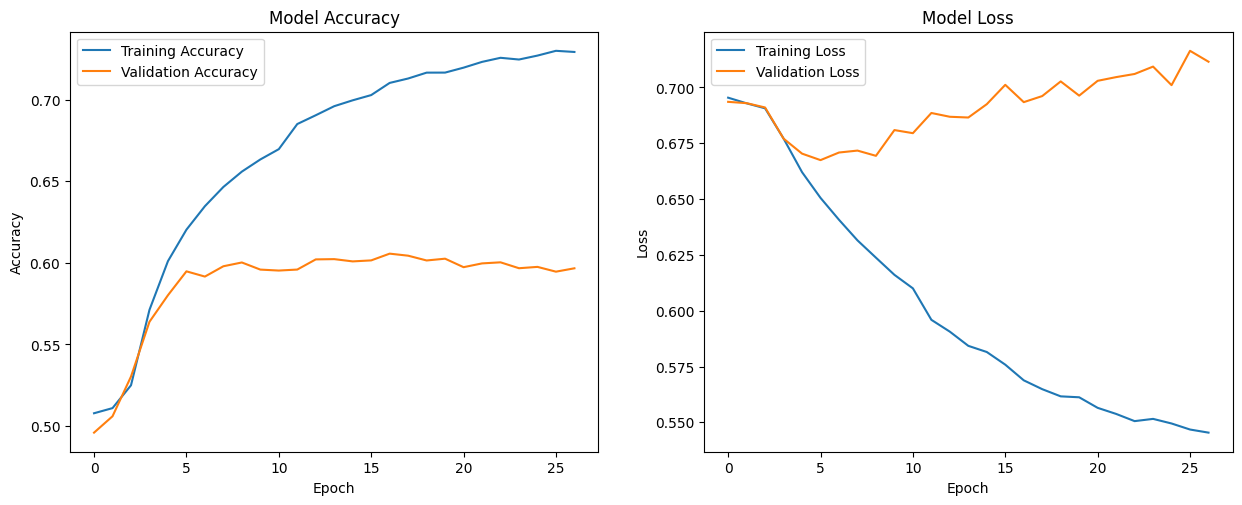

In [ ]:
confidence_bins = np.linspace(0, 1, 6)
bin_accuracy = []

for i in range(len(confidence_bins)-1):
    mask = (y_test_pred_proba_lstm >= confidence_bins[i]) & (y_test_pred_proba_lstm < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_acc = accuracy_score(y_test_seq[mask], y_test_pred_lstm[mask])
        bin_accuracy.append(bin_acc)
    else:
        bin_accuracy.append(0)


# 10. VISUALIZATION
plt.figure(figsize=(15, 12))

# Training history
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()





In [ ]:
bin_accuracy

[0.702928870292887,
 0.6001937984496124,
 0.5367875647668394,
 0.6116345405825914,
 0.6836027713625866]

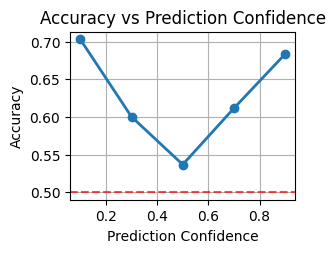

In [ ]:
# Confidence vs Accuracy

baseline_accuracy = np.mean(y_test)

plt.subplot(2, 2, 3)
bin_centers = [(confidence_bins[i] + confidence_bins[i+1])/2 for i in range(len(confidence_bins)-1)]
plt.plot(bin_centers, bin_accuracy, 'o-', linewidth=2)
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Prediction Confidence')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prediction Confidence')
plt.grid(True)


In [ ]:
# 11. TRADING SIMULATION ANALYSIS
# Simple trading simulation based on model predictions
SEQ_LENGTH = 30
def simulate_trading(predictions, actual_returns, confidence_threshold=0.5):
    trading_returns = []
    confidence_filter = y_test_pred_proba_lstm >= confidence_threshold

    for i in range(len(predictions)):
        if confidence_filter[i] and i + SEQ_LENGTH + 1 < len(df_train_features):
            # Get the actual return for the predicted period
            actual_return = df_train_features['returns'].iloc[i + SEQ_LENGTH + 1]
            if predictions[i] == 1:  # Predict up -> go long
                trading_returns.append(actual_return)
            else:  # Predict down -> go short
                trading_returns.append(-actual_return)

    return np.array(trading_returns)

# Run trading simulation
# trading_returns = simulate_trading(y_pred, y_test)

trading_returns = simulate_trading(y_test_pred_lstm, y_test_seq)
if len(trading_returns) > 0:
    sharpe_ratio = np.mean(trading_returns) / np.std(trading_returns) * np.sqrt(252 * 13)  # 13 periods/day
    total_return = np.prod(1 + trading_returns) - 1

    print(f"\nTrading Simulation Results:")
    print(f"Trades taken: {len(trading_returns)}")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Win Rate: {np.mean(trading_returns > 0):.2%}")


Trading Simulation Results:
Trades taken: 22103
Total Return: 25.42%
Sharpe Ratio: 0.35
Win Rate: 49.20%


In [ ]:
lstm_model.save('drive/MyDrive/Group2_Mini_Project/Capstone_Project_Data/models/lstm_1hr_prediction_2_atr_multiplier_all_stocks.keras')

In [ ]:
df_30min_correct = df.resample('30T', origin='start', label='right').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

# Filter only for market hours if needed
df_30min_correct = df_30min_correct.between_time('09:15', '15:30')
print(df_30min_correct.head(3))

                       open    high     low  close    volume
timestamp                                                   
2022-01-03 09:45:00  493.50  499.65  492.70  494.5  11771354
2022-01-03 10:15:00  494.70  495.70  493.35  494.1   2350903
2022-01-03 10:45:00  494.05  495.40  493.70  494.9   1320931


/tmp/ipython-input-2197612373.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min_correct = df.resample('30T', origin='start', label='right').agg({


In [ ]:
df_30min_correct['timestamp'] = df_30min_correct.index

In [ ]:
df_30min_correct

,open,high,low,close,volume,timestamp,symbol
timestamp,,,,,,,
2022-01-03 09:45:00,493.50,499.65,492.70,494.50,11771354,2022-01-03 09:45:00,TATAMOTORS
2022-01-03 10:15:00,494.70,495.70,493.35,494.10,2350903,2022-01-03 10:15:00,TATAMOTORS
2022-01-03 10:45:00,494.05,495.40,493.70,494.90,1320931,2022-01-03 10:45:00,TATAMOTORS
2022-01-03 11:15:00,494.85,496.95,494.55,496.60,1646120,2022-01-03 11:15:00,TATAMOTORS
2022-01-03 11:45:00,496.60,496.70,494.60,495.80,1058781,2022-01-03 11:45:00,TATAMOTORS
...,...,...,...,...,...,...,...
2025-08-08 13:15:00,640.15,641.10,639.20,639.85,475287,2025-08-08 13:15:00,TATAMOTORS
2025-08-08 13:45:00,639.85,640.00,637.20,638.95,499634,2025-08-08 13:45:00,TATAMOTORS
2025-08-08 14:15:00,638.90,638.95,635.10,635.95,814081,2025-08-08 14:15:00,TATAMOTORS


In [ ]:
df_30min_correct['symbol'] = 'TATAMOTORS'

In [ ]:
df_30min_correct['date'] = df_30min_correct.index.date
df_30min_correct['time'] = df_30min_correct.index.time

# Group by date and mark the first occurrence for each day
first_bars = df_30min_correct.groupby('date').head(1).index
df_30min_correct['is_first_bar'] = False
df_30min_correct.loc[first_bars, 'is_first_bar'] = True

# Clean up temporary columns
df_30min_correct = df_30min_correct.drop(['date', 'time'], axis=1)

print(f"Number of overnight gaps identified: {df_30min_correct['is_first_bar'].sum()}")

Number of overnight gaps identified: 892


In [ ]:
df_30min_correct['return'] = df_30min_correct['close'].pct_change()

In [ ]:
df_30min_correct = calculate_features(df)

In [ ]:
##df_intraday_only = df_30min_correct[~df_30min_correct['is_first_bar']].copy()

In [ ]:
df_30min_correct

,timestamp,open,high,low,close,volume,symbol,returns,returns_5,log_returns,...,minute,is_first_hour,is_last_hour,hl_range_pct,upper_shadow,lower_shadow,return_lag_1,return_lag_2,return_lag_5,return_lag_10
50,2022-01-03 13:25:00,496.25,496.35,496.00,496.15,69015,TATAMOTORS,-0.000202,-0.000705,-0.000202,...,25,0,0,0.070543,0.10,0.15,-0.000101,-0.000705,0.002322,-0.000202
51,2022-01-03 13:30:00,496.15,496.30,494.65,495.45,377098,TATAMOTORS,-0.001411,-0.002115,-0.001412,...,30,0,0,0.333031,0.15,0.80,-0.000202,-0.000101,0.000000,-0.000504
52,2022-01-03 13:35:00,495.45,496.00,495.45,495.50,133095,TATAMOTORS,0.000101,-0.002316,0.000101,...,35,0,0,0.110999,0.50,0.00,-0.001411,-0.000202,0.000302,-0.001110
53,2022-01-03 13:40:00,495.50,495.90,495.30,495.85,122345,TATAMOTORS,0.000706,-0.000907,0.000706,...,40,0,0,0.121004,0.05,0.20,0.000101,-0.001411,-0.000705,0.000808
54,2022-01-03 13:45:00,495.90,496.95,495.85,496.95,365341,TATAMOTORS,0.002218,0.001411,0.002216,...,45,0,0,0.221350,0.00,0.05,0.000706,0.000101,-0.000101,0.000202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66822,2025-08-08 15:05:00,635.65,636.35,635.00,635.05,226156,TATAMOTORS,-0.000865,-0.003218,-0.000866,...,5,0,1,0.212582,0.70,0.05,-0.001336,-0.000393,0.000157,0.001258
66823,2025-08-08 15:10:00,635.00,635.20,634.15,634.40,309530,TATAMOTORS,-0.001024,-0.004550,-0.001024,...,10,0,1,0.165511,0.20,0.25,-0.000865,-0.001336,0.000314,-0.000236
66824,2025-08-08 15:15:00,634.40,634.45,632.40,632.60,528091,TATAMOTORS,-0.002837,-0.006439,-0.002841,...,15,0,1,0.324059,0.05,0.20,-0.001024,-0.000865,-0.000941,-0.001335
66825,2025-08-08 15:20:00,632.60,632.80,631.10,632.40,300488,TATAMOTORS,-0.000316,-0.006363,-0.000316,...,20,0,1,0.268817,0.20,1.30,-0.002837,-0.001024,-0.000393,0.000629


In [ ]:
def calculate_features(df):
    """
    Calculate features for multiple stocks in the same dataframe
    """
    # Make sure we have the required columns
    required_columns = ['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    # df = df.reset_index()
    # Sort by symbol and datetime
    # df = df.sort_values(['symbol', 'timestamp']).copy()

    features_list = []

    # Process each stock separately
    for symbol, group in df.groupby('symbol'):
        symbol_df = group.copy()

        # Calculate returns
        symbol_df['returns'] = symbol_df['close'].pct_change()
        symbol_df['returns_5']  = symbol_df['close'].pct_change(5)
        symbol_df['log_returns'] = np.log(symbol_df['close']).diff()
        symbol_df['prev_close'] = symbol_df['close'].shift(1)
        symbol_df['vwap'] = (symbol_df['volume'] * (symbol_df['high'] + symbol_df['low'] + symbol_df['close']) / 3).cumsum() / symbol_df['volume'].cumsum()
        symbol_df['gap'] = (symbol_df['open'] - symbol_df['prev_close']) / symbol_df['prev_close'] * 100
        symbol_df['gap_abs'] = abs(symbol_df['gap'])
        symbol_df['gap_direction'] = np.where(symbol_df['gap'] > 0, 1, np.where(symbol_df['gap'] < 0, -1, 0))
        symbol_df['ema_8'] = symbol_df['close'].ewm(span=8).mean()
        symbol_df['ema_15'] = symbol_df['close'].ewm(span=15).mean()
        ema12 = symbol_df['close'].ewm(span=12, adjust=False).mean()
        ema26 = symbol_df['close'].ewm(span=26, adjust=False).mean()
        symbol_df['macd'] = ema12 - ema26
        symbol_df['macd_signal'] = symbol_df['macd'].ewm(span=9, adjust=False).mean()
        symbol_df['macd_hist'] = symbol_df['macd'] - symbol_df['macd_signal']
        for n in [5, 10, 20]:
         symbol_df[f'roc_{n}'] = symbol_df['close'].pct_change(periods=n)

        df['up_streak'] = df['close'].gt(df['close'].shift()).astype(int)
        df['up_streak'] = df['up_streak'] * (df['up_streak'].groupby((df['up_streak'] != df['up_streak'].shift()).cumsum()).cumsum())


        # Calculate up moves and down moves for RSI calculation
        symbol_df['up_move'] = np.where(symbol_df['close'] > symbol_df['close'].shift(1),
                                       symbol_df['close'] - symbol_df['close'].shift(1), 0)
        symbol_df['down_move'] = np.where(symbol_df['close'] < symbol_df['close'].shift(1),
                                         symbol_df['close'].shift(1) - symbol_df['close'], 0)

        symbol_df["sma_8"] = symbol_df["close"].rolling(window=8).mean()
        symbol_df["sma_20"] = symbol_df["close"].rolling(window=20).mean()

        symbol_df['sma8_above_sma20'] = (symbol_df['sma_8'] > symbol_df['sma_20']).astype(int)
        symbol_df['vwap_sma_20'] = symbol_df['vwap'].rolling(window=20).mean()
        symbol_df['vwap_ratio'] = symbol_df['vwap'] / symbol_df['vwap_sma_20']

        # --- VOLATILITY & RISK FEATURES ---
        # Calculate ATR (Average True Range)
        symbol_df['tr0'] = symbol_df['high'] - symbol_df['low']
        symbol_df['tr1'] = abs(symbol_df['high'] - symbol_df['close'].shift(1))
        symbol_df['tr2'] = abs(symbol_df['low'] - symbol_df['close'].shift(1))
        symbol_df['tr'] = symbol_df[['tr0', 'tr1', 'tr2']].max(axis=1)
        symbol_df['atr'] = symbol_df['tr'].rolling(20).mean()

        symbol_df['volatility_20'] = symbol_df['returns'].rolling(20).std()
        symbol_df['volatility_50'] = symbol_df['returns'].rolling(50).std()
        symbol_df['volatility_ratio'] = symbol_df['volatility_20'] / symbol_df['volatility_50']
        symbol_df['atr_pct'] = symbol_df['atr'] / symbol_df['close']

        # --- PRICE & MOMENTUM FEATURES ---
        # Trend Strength
        for window in [10, 20, 30]:
            symbol_df[f'momentum_{window}'] = symbol_df['close'] / symbol_df['close'].shift(window) - 1

        # Acceleration & Rate of Change
        symbol_df['momentum_roc_10'] = symbol_df['momentum_10'] - symbol_df['momentum_20']

        # RSI Calculation
        symbol_df['rsi_14'] = 100 - (100 / (1 + (symbol_df['up_move'].rolling(14).mean() /
                                               symbol_df['down_move'].rolling(14).mean().replace(0, 0.001))))

        # Bollinger Bands
        bb_window = 20
        symbol_df['bb_mid'] = symbol_df['close'].rolling(bb_window).mean()
        bb_std = symbol_df['close'].rolling(bb_window).std()
        symbol_df['bb_upper'] = symbol_df['bb_mid'] + (bb_std * 2)
        symbol_df['bb_lower'] = symbol_df['bb_mid'] - (bb_std * 2)
        symbol_df['price_vs_bb'] = (symbol_df['close'] - symbol_df['bb_mid']) / (symbol_df['bb_upper'] - symbol_df['bb_lower'])

        # --- VOLUME FEATURES ---
        symbol_df['volume_ma_20'] = symbol_df['volume'].rolling(20).mean()
        symbol_df['volume_ma_50'] = symbol_df['volume'].rolling(50).mean()
        symbol_df['volume_zscore'] = (symbol_df['volume'] - symbol_df['volume_ma_50']) / symbol_df['volume'].rolling(50).std()

        # Volume-Price Confirmation
        symbol_df['volume_price_correlation'] = symbol_df['volume'].rolling(20).corr(symbol_df['close'])

        # On-Balance Volume (OBV)
        symbol_df['obv'] = (np.sign(symbol_df['returns']) * symbol_df['volume']).cumsum()
        symbol_df['obv_ma_ratio'] = symbol_df['obv'] / symbol_df['obv'].rolling(50).mean()

        # --- TIME FEATURES ---
        symbol_df['hour'] = symbol_df['timestamp'].dt.hour
        symbol_df['minute'] = symbol_df['timestamp'].dt.minute
        symbol_df['is_first_hour'] = ((symbol_df['hour'] == 9) |
                                    ((symbol_df['hour'] == 10) & (symbol_df['minute'] < 15))).astype(int)
        symbol_df['is_last_hour'] = (symbol_df['hour'] >= 15).astype(int)

        symbol_df['hl_range_pct'] = (symbol_df['high'] - symbol_df['low']) / symbol_df['close'] * 100
        symbol_df['upper_shadow'] = symbol_df['high'] - symbol_df[['open','close']].max(axis=1)
        symbol_df['lower_shadow'] = symbol_df[['open','close']].min(axis=1) - symbol_df['low']

        # --- LAGGED RETURNS ---
        for lag in [1, 2, 5, 10]:
            symbol_df[f'return_lag_{lag}'] = symbol_df['returns'].shift(lag)

        # Add symbol back to identify which stock this belongs to
        symbol_df['symbol'] = symbol

        features_list.append(symbol_df)

    # Combine all stocks
    df_with_features = pd.concat(features_list, ignore_index=True)

    # Drop all rows with NaN values created by rolling calculations
    df_clean = df_with_features.dropna()

    return df_clean

In [ ]:
!pip install TA-Lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 57.8 MB/s eta 0:00:00


Creating enhanced features...
Enhanced dataset shape: (30241, 69)
Available features: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'returns', 'returns_5', 'log_returns', 'prev_close', 'vwap', 'gap', 'gap_abs', 'gap_direction', 'ema_8', 'ema_15', 'macd', 'macd_signal', 'macd_hist', 'roc_5', 'roc_10', 'roc_20', 'up_move', 'down_move', 'sma_8', 'sma_20', 'sma8_above_sma20', 'vwap_sma_20', 'vwap_ratio', 'tr0', 'tr1', 'tr2', 'tr', 'atr', 'volatility_20', 'volatility_50', 'volatility_ratio', 'atr_pct', 'momentum_10', 'momentum_20', 'momentum_30', 'momentum_roc_10', 'rsi_14', 'bb_mid', 'bb_upper', 'bb_lower', 'price_vs_bb', 'volume_ma_20', 'volume_ma_50', 'volume_zscore', 'volume_price_correlation', 'obv', 'obv_ma_ratio', 'hour', 'minute', 'is_first_hour', 'is_last_hour', 'hl_range_pct', 'upper_shadow', 'lower_shadow', 'return_lag_1', 'return_lag_2', 'return_lag_5', 'return_lag_10', 'future_price', 'price_change', 'atr_threshold', 'target']
X shape: (30241, 37), y shape: 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 30, 64)         │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,513 (158.25 KB)

 Trainable params: 40,321 (157.50 KB)

 Non-trainable params: 192 (768.00 B)

Training advanced LSTM model...
Epoch 1/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5158 - auc: 0.5214 - loss: 0.7093 - val_accuracy: 0.4920 - val_auc: 0.4935 - val_loss: 0.7068 - learning_rate: 0.0010
Epoch 2/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5359 - auc: 0.5482 - loss: 0.6903 - val_accuracy: 0.4905 - val_auc: 0.4967 - val_loss: 0.7107 - learning_rate: 0.0010
Epoch 3/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5499 - auc: 0.5724 - loss: 0.6848 - val_accuracy: 0.4882 - val_auc: 0.4917 - val_loss: 0.7236 - learning_rate: 0.0010
Epoch 4/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5555 - auc: 0.5856 - loss: 0.6810 - val_accuracy: 0.4951 - val_auc: 0.4967 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 5/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5697 - auc: 0.6037 - loss: 0.6751 - val_accuracy: 0.4950 - val_auc: 0.4937 - val_loss: 0.7241 - learning_rate: 0.0010
Epoch 6/100
378/378 ━━━━━━━━━━━━━━━━

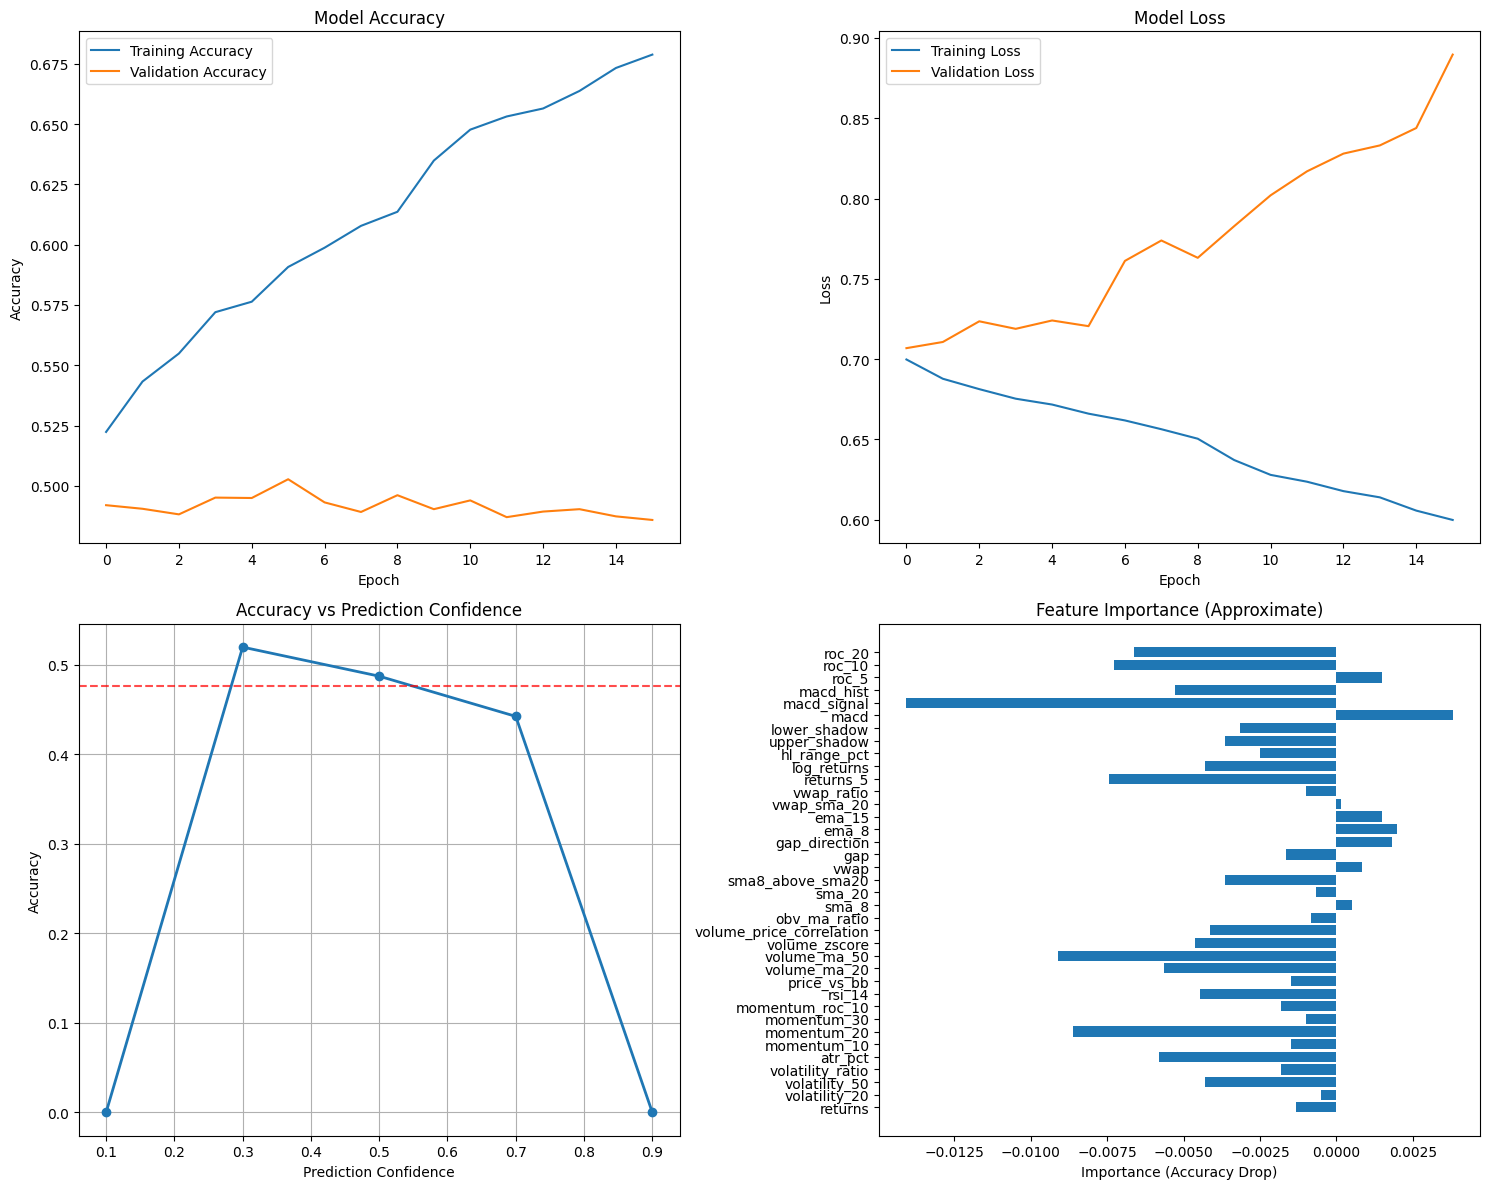


Trading Simulation Results:
Trades taken: 6043
Total Return: 21.41%
Sharpe Ratio: 0.74
Win Rate: 48.97%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
import talib
from scipy import stats

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. ENHANCED FEATURE ENGINEERING
print("Creating enhanced features...")

def create_binary_atr_labels(df, atr_multiplier=1, lookback=6):
    """
    Labels:
        1 = Price moves UP beyond atr_multiplier × ATR within lookback bars
        0 = Price moves DOWN beyond atr_multiplier × ATR within lookback bars
        Rows with no clear up/down breakout are dropped.
    """
    labels_list = []

    for symbol, group in df.groupby('symbol'):
        g = group.copy()
        g['future_price'] = g['close'].shift(-lookback)
        g['price_change'] = g['future_price'] - g['close']
        g['atr_threshold'] = g['atr'] * atr_multiplier

        # Assign 1 for upward breakout, 0 for downward breakout, NaN otherwise
        g['target'] = np.where(
            g['price_change'] > g['atr_threshold'], 1,
            np.where(g['price_change'] < -g['atr_threshold'], 0, np.nan)
        )

        # Keep only definite labels
        g = g.dropna(subset=['future_price', 'atr_threshold', 'target'])

        labels_list.append(g)

    return pd.concat(labels_list, ignore_index=True)

# Create enhanced features
#df_enhanced = create_advanced_features(df_intraday_only)
df_enhanced = create_binary_atr_labels(df_30min_correct)
print(f"Enhanced dataset shape: {df_enhanced.shape}")
print(f"Available features: {list(df_enhanced.columns)}")

# 2. SELECT AND SCALE FEATURES
feature_columns = [
    'returns', 'volatility_20', 'volatility_50', 'volatility_ratio', 'atr_pct',
    'momentum_10', 'momentum_20', 'momentum_30', 'momentum_roc_10', 'rsi_14',
    'price_vs_bb', 'volume_ma_20', 'volume_ma_50', 'volume_zscore',
    'volume_price_correlation', 'obv_ma_ratio', 'sma_8', 'sma_20', 'sma8_above_sma20',
    'vwap', 'gap', 'gap_direction', 'ema_8', 'ema_15', 'vwap_sma_20',
    'vwap_ratio', 'returns_5', 'log_returns', 'hl_range_pct',
    'upper_shadow', 'lower_shadow','macd','macd_signal','macd_hist','roc_5','roc_10','roc_20'
]

target_column = 'target'

X = df_enhanced[feature_columns].values
y = df_enhanced[target_column].values

# Use RobustScaler to handle outliers better
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(f"X shape: {X_scaled.shape}, y shape: {y.shape}")

# 3. CREATE ENHANCED SEQUENCES
def create_enhanced_sequences(features, targets, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i+seq_length])
        y_seq.append(targets[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 30  # Increased sequence length for more context
X_seq, y_seq = create_enhanced_sequences(X_scaled, y, SEQ_LENGTH)

print(f"Sequences created: X_seq shape {X_seq.shape}, y_seq shape {y_seq.shape}")

# 4. TRAIN-TEST SPLIT WITH TIME SERIES AWARENESS
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Training: {X_train.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")

# 5. CLASS BALANCE CHECK
print(f"Class balance - Train: {np.mean(y_train):.3f}, Test: {np.mean(y_test):.3f}")

# 6. IMPROVED LSTM ARCHITECTURE
def create_advanced_lstm_model(input_shape):
    model = Sequential([
        # First LSTM layer
        LSTM(64, activation='tanh', return_sequences=True,
             input_shape=input_shape, recurrent_dropout=0.1),
        BatchNormalization(),
        Dropout(0.3),

        # Second LSTM layer
        LSTM(32, activation='tanh', return_sequences=False,
             recurrent_dropout=0.1),
        BatchNormalization(),
        Dropout(0.3),

        # Dense layers
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dropout(0.2),

        # Output layer (sigmoid for binary classification)
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

# Create model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape, dropout=0.2),
        BatchNormalization(),
        LSTM(32, return_sequences=False, dropout=0.2),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

# 7. ENHANCED TRAINING WITH CALLBACKS
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6,
    verbose=1
)

print("Training advanced LSTM model...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

# 8. COMPREHENSIVE EVALUATION
# Predict probabilities
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
baseline_accuracy = np.mean(y_test)

print("="*60)
print("ADVANCED LSTM MODEL RESULTS")
print("="*60)
print(f"Accuracy: {accuracy:.4f}")
print(f"Baseline (Always Predict Majority): {baseline_accuracy:.4f}")
print(f"Improvement: {accuracy - baseline_accuracy:+.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# 9. CONFIDENCE-BASED PREDICTION ANALYSIS
# Analyze performance by prediction confidence
confidence_bins = np.linspace(0, 1, 6)
bin_accuracy = []

for i in range(len(confidence_bins)-1):
    mask = (y_pred_proba >= confidence_bins[i]) & (y_pred_proba < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_acc = accuracy_score(y_test[mask], y_pred[mask])
        bin_accuracy.append(bin_acc)
    else:
        bin_accuracy.append(0)

# 10. VISUALIZATION
plt.figure(figsize=(15, 12))

# Training history
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Confidence vs Accuracy
plt.subplot(2, 2, 3)
bin_centers = [(confidence_bins[i] + confidence_bins[i+1])/2 for i in range(len(confidence_bins)-1)]
plt.plot(bin_centers, bin_accuracy, 'o-', linewidth=2)
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Prediction Confidence')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Prediction Confidence')
plt.grid(True)

# Feature Importance (approximate using permutation)
def approximate_feature_importance(model, X_test, y_test, feature_names):
    baseline_accuracy = accuracy_score(y_test, model.predict(X_test).flatten() > 0.5)
    importance_scores = []

    for i in range(X_test.shape[2]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, :, i])
        permuted_accuracy = accuracy_score(y_test, model.predict(X_test_permuted).flatten() > 0.5)
        importance_scores.append(baseline_accuracy - permuted_accuracy)

    return importance_scores

feature_importance = approximate_feature_importance(model, X_test, y_test, feature_columns)
plt.subplot(2, 2, 4)
plt.barh(feature_columns, feature_importance)
plt.xlabel('Importance (Accuracy Drop)')
plt.title('Feature Importance (Approximate)')
plt.tight_layout()

plt.tight_layout()
plt.show()

# 11. TRADING SIMULATION ANALYSIS
# Simple trading simulation based on model predictions
def simulate_trading(predictions, actual_returns, confidence_threshold=0.0):
    trading_returns = []
    confidence_filter = y_pred_proba >= confidence_threshold

    for i in range(len(predictions)):
        if confidence_filter[i] and i + SEQ_LENGTH + 1 < len(df_enhanced):
            # Get the actual return for the predicted period
            actual_return = df_enhanced['returns'].iloc[i + SEQ_LENGTH + 1]
            if predictions[i] == 1:  # Predict up -> go long
                trading_returns.append(actual_return)
            else:  # Predict down -> go short
                trading_returns.append(-actual_return)

    return np.array(trading_returns)

# Run trading simulation
trading_returns = simulate_trading(y_pred, y_test)
if len(trading_returns) > 0:
    sharpe_ratio = np.mean(trading_returns) / np.std(trading_returns) * np.sqrt(252 * 13)  # 13 periods/day
    total_return = np.prod(1 + trading_returns) - 1

    print(f"\nTrading Simulation Results:")
    print(f"Trades taken: {len(trading_returns)}")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Win Rate: {np.mean(trading_returns > 0):.2%}")

